# CNN Method

In [20]:
from numpy import array
import keras
import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile

In [21]:
col_list = ["preprocessed_plot","action", "sci-fi", "comedy", "horror","drama","animation",
            "mystery","crime","fantasy","thriller","romance","adventure","biography"]
meta = pd.read_csv("data_for_bert.csv", usecols=col_list)
meta.head()

,preprocessed_plot,action,sci-fi,comedy,horror,drama,animation,mystery,crime,fantasy,thriller,romance,adventure,biography
0,As a Palestinian assassin is targeting promine...,False,False,False,False,True,False,False,False,False,True,False,False,False
1,A girl and her friends find a game in the atti...,False,False,False,True,False,False,False,False,False,False,False,False,False
2,The Earth is invaded by stingray-shaped alien ...,False,True,False,True,False,False,False,False,False,True,False,False,False
3,Józef visits his dying father at a remote ment...,False,False,False,True,True,False,False,False,True,False,False,False,False
4,The life of five-time Formula One world champi...,False,False,False,False,False,False,False,False,False,False,False,False,True


In [22]:
train_set_labels = meta[["action", "sci-fi", "comedy", "horror","drama","animation",
            "mystery","crime","fantasy","thriller","romance","adventure","biography"]]
train_set_labels.head()

,action,sci-fi,comedy,horror,drama,animation,mystery,crime,fantasy,thriller,romance,adventure,biography
0,False,False,False,False,True,False,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False
2,False,True,False,True,False,False,False,False,False,True,False,False,False
3,False,False,False,True,True,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True


In [23]:
X = list(meta["preprocessed_plot"])
y = train_set_labels.values

In [24]:
print(len(X))

31163


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Download only ONCE

In [10]:
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
r = requests.get(url, allow_redirects=True)

open('glove.6B.zip', 'wb').write(r.content)

path_to_zip_file = 'glove.6B.zip'
directory_to_extract_to = 'glove.6B.txt'

In [11]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [27]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.txt/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
input = tf.keras.layers.Input(shape=(maxlen,))
x = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input)

x = tf.keras.layers.Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)

avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.concatenate([avg_pool, max_pool])

preds = tf.keras.layers.Dense(13, activation="sigmoid")(x)

model = tf.keras.Model(input, preds)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-3), metrics=['acc'])

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     3727600     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 198, 64)      19264       embedding_2[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 64)           0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [34]:
batch_size = 128

history = model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size,
          epochs=10, verbose=1)

Epoch 1/10
156/156 [==============================] - 5s 29ms/step - loss: 0.4296 - acc: 0.2822 - val_loss: 0.3847 - val_acc: 0.3389
Epoch 2/10
156/156 [==============================] - 4s 28ms/step - loss: 0.3664 - acc: 0.3608 - val_loss: 0.3599 - val_acc: 0.3708
Epoch 3/10
156/156 [==============================] - 5s 29ms/step - loss: 0.3481 - acc: 0.3764 - val_loss: 0.3522 - val_acc: 0.3863
Epoch 4/10
156/156 [==============================] - 4s 29ms/step - loss: 0.3376 - acc: 0.3900 - val_loss: 0.3470 - val_acc: 0.3787
Epoch 5/10
156/156 [==============================] - 5s 30ms/step - loss: 0.3302 - acc: 0.3972 - val_loss: 0.3441 - val_acc: 0.3791
Epoch 6/10
156/156 [==============================] - 5s 29ms/step - loss: 0.3249 - acc: 0.4007 - val_loss: 0.3420 - val_acc: 0.3753
Epoch 7/10
156/156 [==============================] - 5s 31ms/step - loss: 0.3205 - acc: 0.4089 - val_loss: 0.3411 - val_acc: 0.4011
Epoch 8/10
156/156 [==============================] - 5s 30ms/step - 

In [35]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

195/195 [==============================] - 0s 2ms/step - loss: 0.3404 - acc: 0.3640
Test Score: 0.34044456481933594
Test Accuracy: 0.3640301525592804


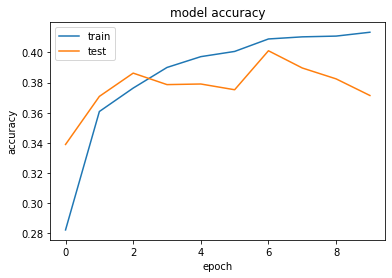

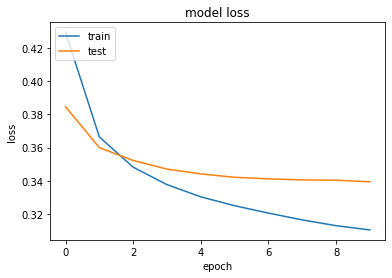

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()